In [1]:
# Importa bibliotecas
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Parameters, report_fit
from matplotlib.widgets import Slider, Button
%matplotlib widget
import nielsen2018_library_demo as ns
import datetime

plt.rcParams["font.family"] = "Garuda"
plt.rc('font', size=14)       # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
change_italic = {'mathtext.default': 'regular' }          
plt.rcParams.update(change_italic)

/tmp/ipykernel_24654/3404005181.py:14: RuntimeWarning: invalid value encountered in log10
  log_i_q_dados = np.log10(i_q_dados)


Area per lipid: 57.86
Lipid volume: 1113.48 (Head: 263 , Tail: 850.48)
Hydrophobic thickness: 29.4
Head thickness: 40.94


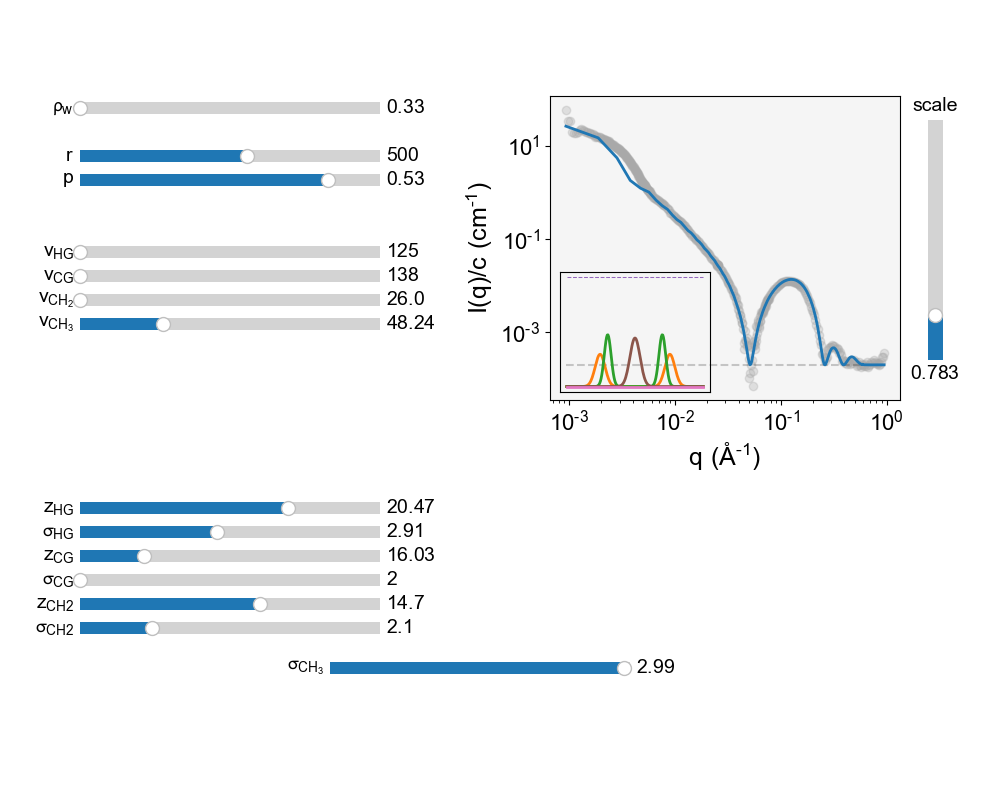

In [15]:
# - - - - - - - - - - - - D A D O S - - - - - - - - - - - - #

data_liposome = np.genfromtxt('/home/lufe/jupyter/Lipossomos/POPS_merge_rebin.dat', names = ['q_data','i_data','err_data'], \
                     delimiter = '	', skip_header = 1, skip_footer = 1)

q_dados = np.zeros(len(data_liposome))
i_q_dados = np.zeros(len(data_liposome))
err_q_dados = np.zeros(len(data_liposome))
for i in range(len(data_liposome)):
    q_dados[i] = data_liposome[i][0]/10 # em Angstrom^-1!
    i_q_dados[i] = data_liposome[i][1]/0.2 # I(q) / (c*espessura)
    err_q_dados[i] = data_liposome[i][2]/0.2 # err(q) / (c*espessura)
log_q_dados = np.log10(q_dados)
log_i_q_dados = np.log10(i_q_dados)
log_err_q_dados = 1/np.log10(err_q_dados) * 1/np.log10(np.exp(1))
q_fit = np.linspace(q_dados[0], q_dados[-1], 1000)

# - - - - - - - - - - - - P A R Â M E T R O S - - - - - - - - - - - - #

liposome = ns.Liposome_Symmetric()

#------------------Parâmetros Lipídios------------------#

liposome.add_param('v_water', value = 29.2, min = 28, max = 30, vary = False) # Angstrom^3
liposome.add_param('Water_Concentration', value = 55.5, vary = False) # em M
n_avogadro = 6.0221408E+23
liposome.add_param('Lipid_Density', value = 1.1E-24, vary = False) # em Angstrom^-3
#v_lipid_ini = mw_lipid / (n_avogadro * d_lipid) #Próximo de volume_total, então deixa este mesmo
#liposome_lipid = 680 # Deixando para o cálculo de concentração explícito
liposome.add_param('MW_Lipid', value = 680, vary = False)
liposome.add_param('Lipid_Concentration', expr = '4e-3', vary = False)
# n_lipidios = concentracao_lipidios * n_avogadro

liposome.add_param('Number_Hydrophobic_Chains', value = 2, vary = False)
liposome.add_param('N_CH2', value = 29, vary = False)
liposome.add_param('N_CH3', value = 2*2, vary = False) # 2 CH3 p/ lipídio, 2 CH3 no grupo
liposome.add_param('Z_HG', value = 94, vary = False)
liposome.add_param('Z_CG', value = 67, vary = False)

liposome.add_param('z_ch2', value = 14.7, min = 13.5, max = 15.5, brute_step=0.5, \
                      vary = False)

# Fixado e determinado anteriormente
liposome.add_param('v_HG', value = 125, min = 125, max = 140, vary = False) # 120
liposome.add_param('v_CG', value = 138, min = 138, max = 155, vary = False) # 143
liposome.add_param('v_head', expr = 'v_CG + v_HG') # 278 pelo Katsaras 2014
liposome.add_param('v_CH2', value = 26.0, min = 26, max = 27.5, vary = False)
# Artigo Nagle 2000, mas pode ser entre 1.9 - 2.1, ou mesmo 1.6 como no atual conjunto de dados (Lund)
## Mas coloquei 1.9 pra já ficar pronto
liposome.add_param('v_CH3', value = 48.24, min = 1.8*liposome.parvals['v_CH2'], max = 2*liposome.parvals['v_CH2'], \
                   vary = False)
liposome.add_param('v_tail', expr = 'N_CH2*v_CH2 + (N_CH3/2)*v_CH3')
# No caso deste ajuste tivemos volume total ajustado de 1163.84792
liposome.add_param('v_lipid', expr = 'v_head + v_tail')
#params.add('v_lipid', value = 1163.84792, vary = False)
# Comprimento_hidrofobico_estimado
liposome.add_param('DC', expr = 'z_ch2')
# Espessura de Luzzati
#liposome.add_param('DB', value = 36.53, vary = False)
#liposome.add_param('area_lipid', value = 65.5, min = 64, max = 70, vary = False)
liposome.add_param('area_lipid', expr = '(v_lipid - v_head)/DC')
liposome.add_param('fracao_lipidios', expr = '(Lipid_Concentration*v_lipid) / (Lipid_Concentration*v_lipid + Water_Concentration*v_water)')
    
#---------------Parâmetros Casca Esférica---------------#

# Deixando explícitos para calcular um em função do outro
liposome.add_param('r', value = 500, min = 250, max = 700, brute_step=20, \
                vary = False) # 382.62978
liposome.add_param('polydispersity', value = 0.53, min = 0.2, max = 0.6, brute_step=5, \
                             vary = False) # 0.29

#------------------Parâmetros Bicamada------------------#

re_angstrom = 2.818E-5 # em Angstrom!
#re_fator = re_angstrom * 1e16 # Conversão de Angstrom para cm
# Lembrando, rho = dens_eletronica * raio_elétron
# Aqui multiplico por 1E-16 para ter tudo em Angstrom^-2. No final posso usar o fator de escala para converter de volta
# Densidade eletrônica do solvente
liposome.add_param('rho_w', value = 0.33, min = 0.330, max = 0.340, \
                    vary = True) #0.333 é o esperado

# HG
# Variar rho_hg de 0.39 a 0.42 A^-3 * re
liposome.add_param('rho_hg', expr = 'Z_HG/v_HG') # Valor ajuste: 1.51192771E+11*1E-16
liposome.add_param('z_hg', value = 20.47, min = 17, max = 22, brute_step=0.5, \
                     vary = True)
liposome.add_param('sigma_hg', value = 2.91, min = 2.0, max = 4.0, brute_step=1.0, \
                         vary = True)
liposome.add_param('c_hg', expr = 'v_HG/(area_lipid*sigma_hg)')
# CG
liposome.add_param('rho_cg', expr = 'Z_CG/v_CG') # Valor ajuste: 1.38235294E+11*1E-16
liposome.add_param('z_cg', value = 16.03, min = 15.5, max = 18.0, brute_step=0.5, \
                     vary = True) # 13.6262141
liposome.add_param('sigma_cg', value = 2.0, min = 2.0, max = 4.0, brute_step=1.0, \
                         vary = True) # 2.23808212
liposome.add_param('c_cg', expr = 'v_CG/(area_lipid*sigma_cg)')
# CH2
# Variar rho_ch2 de 0.25 a 0.33 A^-3 * re
liposome.add_param('rho_ch2', expr = '8/v_CH2') # Valor ajuste: 7.91110737E+10*1E-16
liposome.add_param('sigma_ch2', value = 2.1, min = 1.5, max = 4, brute_step=1.0, \
                          vary = False) # 5.5
# CH3
# Variar rho_ch3 de 0.15 a 0.20 A^3 * re
liposome.add_param('rho_ch3', expr = '9/v_CH3')
liposome.add_param('z_ch3', value = 0, \
                    vary = False) #FIXO#
liposome.add_param('sigma_ch3', value = 2.99, min = 2.5, max = 3.0, brute_step=1.0, \
                        vary = False) #GERALMENTE FIXO# # 2.5
liposome.add_param('c_ch3', expr = 'N_CH3*v_CH3/(area_lipid*sigma_ch3)')
# Voltando à esfera para associar distâncias entre elementos da membrana à espessura t_shell
# O '-' é por causa do sinal pra achar a média entre os z
#t_shell_ = (z_hg_o_ - z_hg_i_)
liposome.add_param('p_agg', \
           expr = '(4*3.1416*r**3 - 4*3.1416*(r - (2*z_hg))**3) / (3*v_tail)')
                                              ## + porque z_hg_i é negativo!!!
                                              ## Vtail é para cada cauda hidrofóbica
liposome.add_param('n_scatterers', expr = 'fracao_lipidios/(v_lipid*p_agg)')

#------------------Scaling fator and background------------------#

# 1E+8 factor: conversion from Angstrom ^-1 to cm^-1!
liposome.add_param('scale', value = 0.783, min = 0.5, max = 2, vary = True)
liposome.add_param('background', value = 20, min = 0, max = 500, \
                    vary = False)

liposome.load_data(q_fit, i_q_dados, err_q_dados)
liposome.load_all()



#-----------------------------------------------------------#

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.scatter(q_dados, i_q_dados, label = 'Data', color = 'darkgray', alpha = 0.3)
background_plot = ax.hlines(y=liposome.parvals['background'], xmin=q_dados[0], xmax=q_dados[-1], color = 'k', linestyle = 'dashed', alpha = 0.2)
line, = ax.plot(liposome.q, liposome.intensities, label = 'Our calculations', linewidth = 2)
fig.subplots_adjust(left=0.55, bottom=0.5)
ax2 = fig.add_axes([0.56,0.51,0.15,0.15])
p_hg, = ax2.plot(liposome.z_array, liposome.volume_distributions['p_hg'], color = cycle[1], linewidth = 2, \
                 label = 'P$_{HG}$')
p_cg, = ax2.plot(liposome.z_array, liposome.volume_distributions['p_cg'], color = cycle[2], linewidth = 2, \
                 label = 'P$_{CG}$')
p_ch3, = ax2.plot(liposome.z_array, liposome.volume_distributions['p_ch3'], color = cycle[5], linewidth = 2, \
                  label = 'P$_{CH_3}$')
p_ch2, = ax2.plot(liposome.z_array, liposome.volume_distributions['p_ch2'], color = cycle[6], linewidth = 2, \
                  label = 'P$_{CH_2}$')
#p_p, = ax2.plot(liposome.z_array, liposome.volume_distributions['p_p'], color = cycle[0], linewidth = 2, \
#                label = 'P$_{P}$')
p_w, = ax2.plot(liposome.z_array, liposome.volume_distributions['p_water'], color = cycle[4], linewidth = 0.75, \
                linestyle = 'dashed', label = 'P$_w$')

# Horizontal sliders
ax_rho_w = fig.add_axes([0.08, 0.85, 0.3, 0.03])
rho_w_slider = Slider(
    ax=ax_rho_w,
    label=r'$\rho_w$',
    valmin=liposome.params['rho_w'].min,
    valmax=liposome.params['rho_w'].max,
    valinit=liposome.params['rho_w'].value,
)

ax_r = fig.add_axes([0.08, 0.79, 0.3, 0.03])
r_slider = Slider(
    ax=ax_r,
    label=r'$r$',
    valmin=liposome.params['r'].min,
    valmax=liposome.params['r'].max,
    valinit=liposome.params['r'].value,
)
ax_p = fig.add_axes([0.08, 0.76, 0.3, 0.03])
p_slider = Slider(
    ax=ax_p,
    label=r'$p$',
    valmin=liposome.params['polydispersity'].min,
    valmax=liposome.params['polydispersity'].max,
    valinit=liposome.params['polydispersity'].value,
)

## Sliders laterais para mudar as densidades eletrônicas
#ax_a_lipid = fig.add_axes([0.08, 0.70, 0.3, 0.03])
#a_lipid_slider = Slider(
#    ax=ax_a_lipid,
#    label="a_lip",
#    valmin=liposome.params['area_lipid'].min,
#    valmax=liposome.params['area_lipid'].max,
#    valinit=liposome.params['area_lipid'].value,
#    orientation="horizontal",
#)
ax_v_hg = fig.add_axes([0.08, 0.67, 0.3, 0.03])
v_hg_slider = Slider(
    ax=ax_v_hg,
    label=r"$v_{HG}$",
    valmin=liposome.params['v_HG'].min,
    valmax=liposome.params['v_HG'].max,
    valinit=liposome.params['v_HG'].value,
    orientation="horizontal",
)
ax_v_cg = fig.add_axes([0.08, 0.64, 0.3, 0.03])
v_cg_slider = Slider(
    ax=ax_v_cg,
    label=r"$v_{CG}$",
    valmin=liposome.params['v_CG'].min,
    valmax=liposome.params['v_CG'].max,
    valinit=liposome.params['v_CG'].value,
    orientation="horizontal",
)
ax_v_ch2 = fig.add_axes([0.08, 0.61, 0.3, 0.03])
v_ch2_slider = Slider(
    ax=ax_v_ch2,
    label=r"$v_{CH_2}$",
    valmin=liposome.params['v_CH2'].min,
    valmax=liposome.params['v_CH2'].max,
    valinit=liposome.params['v_CH2'].value,
    orientation="horizontal",
)
ax_v_ch3 = fig.add_axes([0.08, 0.58, 0.3, 0.03])
v_ch3_slider = Slider(
    ax=ax_v_ch3,
    label=r"$v_{CH_3}$",
    valmin=liposome.params['v_CH3'].min,
    valmax=liposome.params['v_CH3'].max,
    valinit=liposome.params['v_CH3'].value,
    orientation="horizontal",
)

ax_z_hg = fig.add_axes([0.08, 0.35, 0.3, 0.03])
z_hg_slider = Slider(
    ax=ax_z_hg,
    label=r'$z_{HG}$',
    valmin=liposome.params['z_hg'].min,
    valmax=liposome.params['z_hg'].max,
    valinit=liposome.params['z_hg'].value,
)
ax_sigma_hg = fig.add_axes([0.08, 0.32, 0.3, 0.03])
sigma_hg_slider = Slider(
    ax=ax_sigma_hg,
    label=r'$\sigma_{HG}$',
    valmin=liposome.params['sigma_hg'].min,
    valmax=liposome.params['sigma_hg'].max,
    valinit=liposome.params['sigma_hg'].value,
)
ax_z_cg = fig.add_axes([0.08, 0.29, 0.3, 0.03])
z_cg_slider = Slider(
    ax=ax_z_cg,
    label=r'$z_{CG}$',
    valmin=liposome.params['z_cg'].min,
    valmax=liposome.params['z_cg'].max,
    valinit=liposome.params['z_cg'].value,
)
ax_sigma_cg = fig.add_axes([0.08, 0.26, 0.3, 0.03])
sigma_cg_slider = Slider(
    ax=ax_sigma_cg,
    label=r'$\sigma_{CG}$',
    valmin=liposome.params['sigma_cg'].min,
    valmax=liposome.params['sigma_cg'].max,
    valinit=liposome.params['sigma_cg'].value,
)
ax_z_ch2 = fig.add_axes([0.08, 0.23, 0.3, 0.03])
z_ch2_slider = Slider(
    ax=ax_z_ch2,
    label=r'$z_{CH2}$',
    valmin=liposome.params['z_ch2'].min,
    valmax=liposome.params['z_ch2'].max,
    valinit=liposome.params['z_ch2'].value,
)
ax_sigma_ch2 = fig.add_axes([0.08, 0.20, 0.3, 0.03])
sigma_ch2_slider = Slider(
    ax=ax_sigma_ch2,
    label=r'$\sigma_{CH2}$',
    valmin=liposome.params['sigma_ch2'].min,
    valmax=liposome.params['sigma_ch2'].max,
    valinit=liposome.params['sigma_ch2'].value,
)
ax_sigma_ch3 = fig.add_axes([0.33, 0.15, 0.3, 0.03])
sigma_ch3_slider = Slider(
    ax=ax_sigma_ch3,
    label=r'$\sigma_{CH_3}$',
    valmin=liposome.params['sigma_ch3'].min,
    valmax=liposome.params['sigma_ch3'].max,
    valinit=liposome.params['sigma_ch3'].value,
)

# Vertical sliders
ax_scale = fig.add_axes([0.92, 0.55, 0.03, 0.3])
scale_slider = Slider(
    ax=ax_scale,
    label="scale",
    valmin=liposome.params['scale'].min,
    valmax=liposome.params['scale'].max,
    valinit=liposome.params['scale'].value,
    orientation="vertical",
)

def update(val):
    liposome.add_param('rho_w', value = rho_w_slider.val, min = liposome.params['rho_w'].min, \
                       max = liposome.params['rho_w'].max, vary = liposome.params['rho_w'].vary)
    liposome.add_param('r', value = r_slider.val, min = liposome.params['r'].min, \
                       max = liposome.params['r'].max, vary = liposome.params['r'].vary)
    liposome.add_param('polydispersity', value = p_slider.val, min = liposome.params['polydispersity'].min, \
                       max = liposome.params['polydispersity'].max, vary = liposome.params['polydispersity'].vary)
#    liposome.add_param('area_lipid', value = a_lipid_slider.val, min = liposome.params['area_lipid'].min, \
#                       max = liposome.params['area_lipid'].max, vary = liposome.params['area_lipid'].vary)
    liposome.add_param('v_HG', value = v_hg_slider.val, min = liposome.params['v_HG'].min, \
                       max = liposome.params['v_HG'].max, vary = liposome.params['v_HG'].vary)
    liposome.add_param('v_CG', value = v_cg_slider.val, min = liposome.params['v_CG'].min, \
                       max = liposome.params['v_CG'].max, vary = liposome.params['v_CG'].vary)
    liposome.add_param('v_CH2', value = v_ch2_slider.val, min = liposome.params['v_CH2'].min, \
                       max = liposome.params['v_CH2'].max, vary = liposome.params['v_CH2'].vary)
    liposome.add_param('v_CH3', value = v_ch3_slider.val, min = liposome.params['v_CH3'].min, \
                       max = liposome.params['v_CH3'].max, vary = liposome.params['v_CH3'].vary)
    liposome.add_param('z_hg', value = z_hg_slider.val, min = liposome.params['z_hg'].min, \
                       max = liposome.params['z_hg'].max, vary = liposome.params['z_hg'].vary)
    liposome.add_param('sigma_hg', value = sigma_hg_slider.val, min = liposome.params['sigma_hg'].min, \
                       max = liposome.params['sigma_hg'].max, vary = liposome.params['sigma_hg'].vary)
    liposome.add_param('z_cg', value = z_cg_slider.val, min = liposome.params['z_cg'].min, \
                       max = liposome.params['z_cg'].max, vary = liposome.params['z_cg'].vary)
    liposome.add_param('sigma_cg', value = sigma_cg_slider.val, min = liposome.params['sigma_cg'].min, \
                       max = liposome.params['sigma_cg'].max, vary = liposome.params['sigma_cg'].vary)
    liposome.add_param('z_ch2', value = z_ch2_slider.val, min = liposome.params['z_ch2'].min, \
                       max = liposome.params['z_ch2'].max, vary = liposome.params['z_ch2'].vary)
    liposome.add_param('sigma_ch2', value = sigma_ch2_slider.val, min = liposome.params['sigma_ch2'].min, \
                       max = liposome.params['sigma_ch2'].max, vary = liposome.params['sigma_ch2'].vary)
    liposome.add_param('sigma_ch3', value = sigma_ch3_slider.val, min = liposome.params['sigma_ch3'].min, \
                       max = liposome.params['sigma_ch3'].max, vary = liposome.params['sigma_ch3'].vary)
    liposome.add_param('scale', value = scale_slider.val, min = liposome.params['scale'].min, \
                       max = liposome.params['scale'].max, vary = liposome.params['scale'].vary)
    liposome.load_all()
    line.set_ydata(liposome.intensities)
    p_hg.set_ydata(liposome.volume_distributions['p_hg'])
    p_cg.set_ydata(liposome.volume_distributions['p_cg'])
    p_ch3.set_ydata(liposome.volume_distributions['p_ch3'])
    p_ch2.set_ydata(liposome.volume_distributions['p_ch2'])
    p_w.set_ydata(liposome.volume_distributions['p_water'])
    fig.canvas.draw_idle()
    
# register the update function with each slider
rho_w_slider.on_changed(update)
r_slider.on_changed(update)
p_slider.on_changed(update)
#a_lipid_slider.on_changed(update)
v_hg_slider.on_changed(update)
v_cg_slider.on_changed(update)
v_ch2_slider.on_changed(update)
v_ch3_slider.on_changed(update)
z_hg_slider.on_changed(update)
sigma_hg_slider.on_changed(update)
z_cg_slider.on_changed(update)
sigma_cg_slider.on_changed(update)
z_ch2_slider.on_changed(update)
sigma_ch2_slider.on_changed(update)
sigma_ch3_slider.on_changed(update)
scale_slider.on_changed(update)

print('Area per lipid: ' + str(round(liposome.params['area_lipid'].value,2)))
print('Lipid volume: ' + str(round(liposome.params['v_lipid'].value,2)) + \
      ' (Head: ' + str(round(liposome.params['v_head'].value,2)) + \
      ' , Tail: ' + str(round(liposome.params['v_tail'].value,2)) + ')')
print('Hydrophobic thickness: ' + str(round(2*liposome.params['DC'].value,2)))
print('Head thickness: ' + str(round(2*liposome.params['z_hg'].value,2)))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('q ($\AA^{-1}$)')
ax.set_ylabel('I(q)/c (cm$^{-1}$)')
#ax2.set_xlabel('z ($\AA$)', fontsize = 8)
#ax2.set_ylabel('P$_n$(z) ($\AA$)', fontsize = 8)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.tick_params(labelbottom=False) 
ax2.set_facecolor('none')
#ax.legend(frameon=False)
ax.set_facecolor('whitesmoke')
#plt.title('Playing with sliders')
plt.show()

In [19]:
# --------------------------------------------------------------- #

# Choosing min and max values for fitting range
q_min_fit = 0.01
q_max_fit = 0.6
# Finding index for these q values
q_min_index = liposome.find_nearest_index(q_dados, q_min_fit)
q_max_index = liposome.find_nearest_index(q_dados, q_max_fit)
# "Cutting" arrays for fitting
q_dados_fit = liposome.escolhe_pontos(q_dados, q_min_index, q_max_index)
i_q_dados_fit = liposome.escolhe_pontos(i_q_dados, q_min_index, q_max_index)
err_q_dados_fit = liposome.escolhe_pontos(err_q_dados, q_min_index, q_max_index)
log_q_dados_fit = liposome.escolhe_pontos(log_q_dados, q_min_index, q_max_index)
log_i_q_dados_fit = liposome.escolhe_pontos(log_i_q_dados, q_min_index, q_max_index)
log_err_q_dados_fit = liposome.escolhe_pontos(log_err_q_dados, q_min_index, q_max_index)

# - - - - - - - - - - - - Fitting Functions - - - - - - - - - - - - #

def residuo_membrana_relative(parameters, q_res, i_q_res, err_q_res):
    liposome_model = ns.Liposome_Symmetric(q = q_res, i_q = i_q_res, err_q = err_q_res, peptide = False)
    for param in liposome.params:
        liposome_model.add_param(liposome.params[param].name, value = liposome.params[param].value, min = liposome.params[param].min, \
                       max = liposome.params[param].max, vary = liposome.params[param].vary)
    liposome_model.load_data(q = q_res, i_q = i_q_res, err_q = err_q_res)
    liposome_model.load_all()
    return (liposome_model.log_i_q - liposome_model.log_intensities) / liposome_model.log_err_q

def residuo_membrana_absolute(parameters, q_res, i_q_res):
    liposome_model = ns.Liposome_Symmetric(q = q_res, i_q = i_q_res, peptide = False)
    for param in parameters:
        liposome_model.add_param(parameters[param].name, value = parameters[param].value, min = parameters[param].min, \
                       max = parameters[param].max, vary = parameters[param].vary)
    liposome_model.load_data(q = q_res, i_q = i_q_res)
    liposome_model.load_all()
    return liposome_model.log_i_q - liposome_model.log_intensities

def adjustments(pars, iteration, residuals, x, y):
    if (iteration % 1000 == 0) and (iteration != 0):
        print('Number of iterations so far: ' + str(iteration), end='\n')
    else:
        pass

In [20]:
#------------------Fitting------------------#

# Minimization loop
repeats = 1
intensities_fits = []
results_list = []
best_chi_index = 0
for i in range(repeats):
    print('Minimization process number ' + str(i+1) + '/' + str(repeats))
    print('')
    result = liposome.ajusta_geral(q_dados_fit, i_q_dados_fit, \
                residuo_membrana_absolute, liposome.params, callback = adjustments, \
                passo = 1E-8, method = 'nm-lm', perturbations = True)
    analysis_fit = ns.Liposome_Symmetric(q = q_dados, i_q = i_q_dados, peptide = False)
    for param in result.params:
        analysis_fit.add_param(result.params[param].name, value = result.params[param].value, min = result.params[param].min, \
                                 max = result.params[param].max, vary = result.params[param].vary)
    analysis_fit.load_data(q = q_dados, i_q = i_q_dados)
    analysis_fit.load_all()
    intensities_fits.append(analysis_fit.intensities)
    results_list.append(result)
    # Keeps best chi^2
    if i > 0:
        if results_list[i].chisqr < results_list[best_chi_index].chisqr:
            best_chi_index = i
        else:
            pass
    else:
        pass
    print('')

result = results_list[best_chi_index]
# write error report
report_fit(result)
print('')
print('Area per lipid: ' + str(round(result.params['area_lipid'].value,2)))
print('Lipid volume: ' + str(round(result.params['v_lipid'].value,2)) + \
      ' (Head: ' + str(round(result.params['v_head'].value,2)) + \
      ' , Tail: ' + str(round(result.params['v_tail'].value,2)) + ')')
print('Hydrophobic thickness: ' + str(round(2*result.params['DC'].value,2)))
print('Head thickness: ' + str(round(2*result.params['z_hg'].value,2)))

print('')
print('rho_w: ' + str(round(result.params['rho_w'].value,2)))
print('rho_HG: ' + str(round(result.params['Z_HG']/result.params['v_HG'].value,2)))
print('rho_CG: ' + str(round(result.params['Z_CG']/result.params['v_CG'].value,2)))
print('rho_CH2: ' + str(round(8/result.params['v_CH2'].value,2)))
print('rho_CH3: ' + str(round(9/result.params['v_CH3'].value,2)))

Minimization process number 1/1

Number of iterations so far: 1000
Number of iterations so far: 2000
Number of iterations so far: 3000

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3235
    # data points      = 223
    # variables        = 6
    chi-square         = 1.95007697
    reduced chi-square = 0.00898653
    Akaike info crit   = -1044.86455
    Bayesian info crit = -1024.42152
##  Warning: uncertainties could not be estimated:
    rho_w:                      at boundary
    sigma_cg:                   at boundary
[[Variables]]
    v_water:                    29.2 (fixed)
    Water_Concentration:        55.5 (fixed)
    Lipid_Density:              1.1e-24 (fixed)
    MW_Lipid:                   680 (fixed)
    Lipid_Concentration:        0.00400000 == '4e-3'
    Number_Hydrophobic_Chains:  2 (fixed)
    N_CH2:                      29 (fixed)
    N_CH3:                      4 (fixed)
    Z_HG:                       94 (fixed)
    Z_CG:             

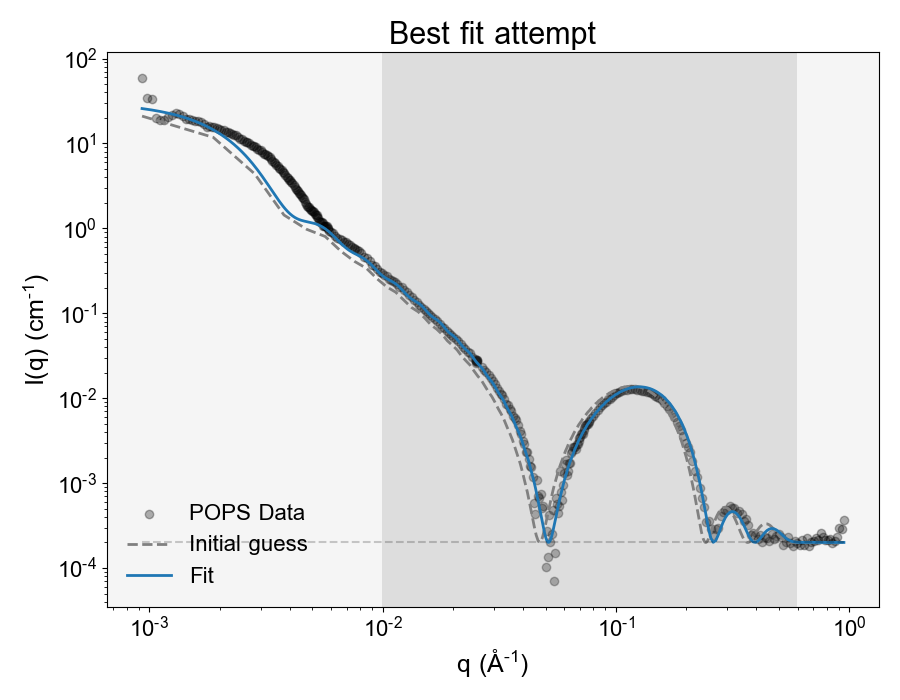

/tmp/ipykernel_24654/2488562041.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


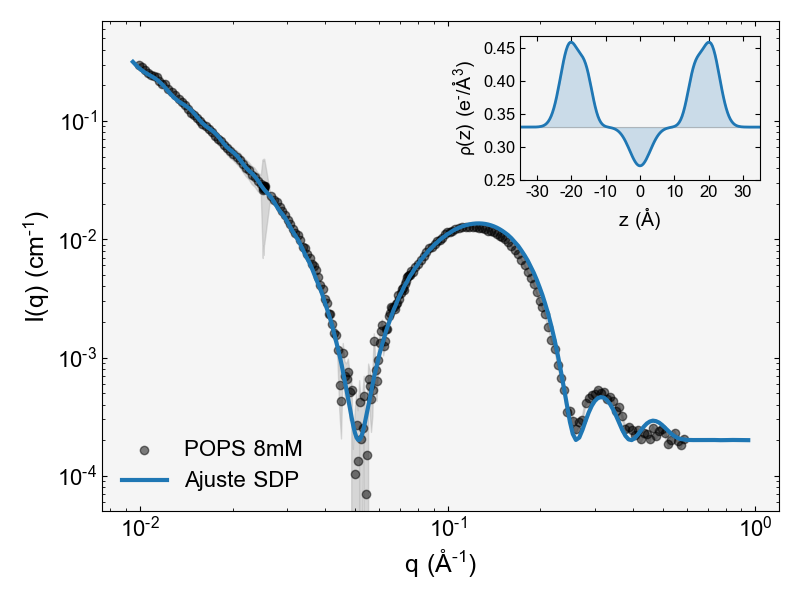

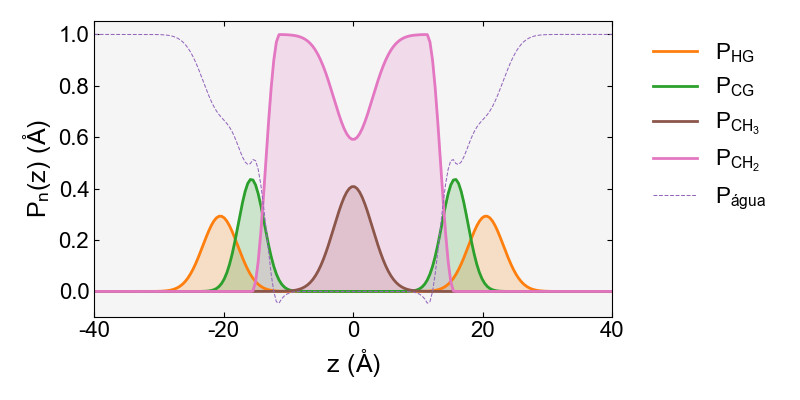

In [21]:
q_data_fit = np.linspace(q_dados[0], q_dados[-1], 2000)

# Calculates fitting array
best_fit = ns.Liposome_Symmetric(q = q_dados, i_q = i_q_dados, peptide = False)
for param in result.params:
    best_fit.add_param(result.params[param].name, value = result.params[param].value, min = result.params[param].min, \
                             max = result.params[param].max, vary = result.params[param].vary)
best_fit.load_data(q = q_dados, i_q = i_q_dados)
best_fit.load_all()

#--------------Data--------------#

if repeats > 1:
    # Plota todos os ajustes tentados
    fig = plt.figure(figsize=(9,7))
    ax = fig.add_subplot(1, 1, 1)
    ax.scatter(q_dados, i_q_dados, color = 'k', alpha = 0.3, label = 'Liposomes Data')
    #plt.errorbar(q_dados, i_q_dados, yerr = err_q_dados)
    plt.axvspan(q_dados[q_min_index], q_dados[q_max_index], color='gray', alpha=0.2, lw=0)
    #ax.hlines(y=liposome.params['background'].value*1e-4, xmin=q_dados[0], xmax=q_dados[-1], color = 'k', linestyle = 'dashed', alpha = 0.2)
    ax.plot(liposome.q, liposome.intensities, label = 'Initial guess', \
            linewidth = 2, color = 'gray', linestyle = 'dashed')
    for i in range(repeats):
        ax.plot(q_dados, intensities_fits[i], alpha = 0.7, label = 'Fitting attempt ' + str(i+1))
    background_plot = ax.hlines(y=0.00015, xmin=q_dados[0], xmax=q_dados[-1], color = 'k', linestyle = 'dashed', alpha = 0.2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('q ($\AA^{-1}$)')
    ax.set_ylabel('I(q) (cm$^{-1}$)')
    ax.legend(frameon=False)
    ax.set_facecolor('whitesmoke')
    plt.title('Multiple fit attempts')
#    plt.savefig('liposomes_test_fit_attempts.png', dpi = 300)
    plt.show()
else:
    pass

# Plots best fit
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(q_dados, i_q_dados, color = 'k', alpha = 0.3, label = 'Liposomes Data')
#plt.errorbar(q_dados, i_q_dados, yerr = err_q_dados, color = 'darkgray', alpha = 0.3)
plt.axvspan(q_dados[q_min_index], q_dados[q_max_index], color='gray', alpha=0.2, lw=0)
ax.plot(liposome.q, liposome.intensities, label = 'Initial guess', \
        linewidth = 2, color = 'gray', linestyle = 'dashed')
ax.plot(best_fit.q, best_fit.intensities, label = 'Fit', linewidth = 2)
background_plot = ax.hlines(y=best_fit.params['background'].value*1e-5, xmin=q_dados[0], xmax=q_dados[-1], color = 'k', linestyle = 'dashed', alpha = 0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('q ($\AA^{-1}$)')
ax.set_ylabel('I(q) (cm$^{-1}$)')
ax.legend(frameon=False)
#ax.set_ylim(top = 20)
ax.set_facecolor('whitesmoke')
plt.title('Best fit attempt')
plt.tight_layout()
#plt.savefig('test_fit_best.png', dpi = 300)
plt.show()

q_data_fit = np.linspace(q_dados[0], q_dados[-1], 2000)

# Calculates fitting array
best_fit = ns.Liposome_Symmetric(q = q_dados, i_q = i_q_dados, peptide = False)
for param in result.params:
    best_fit.add_param(result.params[param].name, value = result.params[param].value, min = result.params[param].min, \
                             max = result.params[param].max, vary = result.params[param].vary)
best_fit.load_data(q = q_dados, i_q = i_q_dados)
best_fit.load_all()
base_rho_water = (best_fit.parvals['rho_w'] / best_fit.e_radius)*np.ones(len(best_fit.rho_distribution))
best_fit.gera_p_hc
p_ch2_manual = best_fit.p_hc - best_fit.p_ch3
rho_ch2_manual = p_ch2_manual * np.ones(len(p_ch2_manual)) * 8/best_fit.parvals['v_CH2']
rho_final_manual = best_fit.rho_distribution + rho_ch2_manual
p_water_manual = 1 - (best_fit.p_hc + best_fit.p_hg + best_fit.p_cg)

# Figures
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
ax2 = fig.add_axes([0.65,0.7,0.3,0.24])
ax.fill_between(x = q_dados_fit, y1 = i_q_dados_fit - err_q_dados_fit, y2 = i_q_dados_fit + err_q_dados_fit, color = 'darkgray', alpha= 0.4)
ax.scatter(q_dados_fit, i_q_dados_fit, color = 'k', alpha = 0.5, label = 'Lipids 8mM')
ax.plot(best_fit.q[130:], best_fit.intensities[130:], label = 'SDP Fit', linewidth = 3)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim()
ax.set_ylim(bottom = 5e-5, top = 0.7)
ax.set_xlabel('q ($\AA^{-1}$)')
ax.set_ylabel('I(q) (cm$^{-1}$)')
ax.legend(frameon=False, loc = 'lower left')
#ax.set_ylim(top = 20)
ax.set_facecolor('whitesmoke')
ax.tick_params(which = 'both', direction = 'in', \
                      labelbottom=True, labeltop=False, labelleft=True, labelright=False, \
                      bottom=True, top=True, left=True, right=True)
ax2.plot(best_fit.z_array, base_z+base_rho_water, color = 'darkgray', linewidth = 0.5)
ax2.plot(best_fit.z_array, best_fit.rho_distribution+base_rho_water, color = cycle[0], linewidth = 2)
ax2.fill_between(x = best_fit.z_array, y1 = best_fit.rho_distribution+base_rho_water, y2 = base_z+base_rho_water, color = cycle[0], alpha= 0.2)
ax2.set_facecolor('whitesmoke')
ax2.set_xlim(-35,35)
ax2.set_xlabel('z ($\AA$)', fontsize = 14)
ax2.set_ylabel(r'$\rho$(z) ($e^{-}/\AA^{3}$)', fontsize = 14)
ax2.set_xticks(np.arange(-30, 30.1, 10))
ax2.set_yticks(np.arange(0.25, 0.50, 0.05))
ax2.tick_params(which = 'both', direction = 'in', \
                      labelbottom=True, labeltop=False, labelleft=True, labelright=False, \
                      bottom=True, top=True, left=True, right=True, labelsize = 12)
plt.tight_layout()
#plt.savefig('liposome_fit.png', dpi = 300)
plt.show()

#------------Membrane components distribution------------#

# Plots radial p_n(z)
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(1, 1, 1)
#ax.plot(best_fit.z_array, best_fit.p_p, color = cycle[0], linewidth = 2, label = 'P$_P$')
ax.plot(best_fit.z_array, best_fit.p_hg, color = cycle[1], linewidth = 2, label = 'P$_{HG}$')
ax.plot(best_fit.z_array, best_fit.p_cg, color = cycle[2], linewidth = 2, label = 'P$_{CG}$')
ax.plot(best_fit.z_array, best_fit.p_ch3, color = cycle[5], linewidth = 2, label = 'P$_{CH_3}$')
ax.plot(best_fit.z_array, p_ch2_manual, color = cycle[6], linewidth = 2, label = 'P$_{CH_2}$')
ax.plot(best_fit.z_array, p_water_manual, color = cycle[4], linewidth = 0.75, linestyle = 'dashed', label = r'P$_{água}$')
ax.fill_between(x = best_fit.z_array, y1 = best_fit.p_hg, color = cycle[1], alpha= 0.2)
ax.fill_between(x = best_fit.z_array, y1 = best_fit.p_cg, color = cycle[2], alpha= 0.2)
ax.fill_between(x = best_fit.z_array, y1 = best_fit.p_ch3, color = cycle[5], alpha= 0.2)
ax.fill_between(x = best_fit.z_array, y1 = p_ch2_manual, color = cycle[6], alpha= 0.2)
ax.set_xlim(-40,40)
#plt.plot(z_array, p_soma_real, label = 'Soma')
#ax.fill_between(x = best_fit.z_array, y1 = best_fit.p_p, color = cycle[0], alpha= 0.2)
ax.set_facecolor('whitesmoke')
plt.legend(frameon=False, bbox_to_anchor=(1.04, 1))
plt.xlabel('z ($\AA$)')
plt.ylabel('P$_n$(z) ($\AA$)')
ax.tick_params(which = 'both', direction = 'in', \
                      labelbottom=True, labeltop=False, labelleft=True, labelright=False, \
                      bottom=True, top=True, left=True, right=True)
plt.tight_layout()
#plt.savefig('membrane_rho.png', dpi = 300)
plt.show()